<a href="https://colab.research.google.com/github/Risuo/Risuo.github.io/blob/master/inspect_buildings_training_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN - Inspect Building Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

import colorsys
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/')
sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets')
sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/samples/nucleus')
sys.path.append('/content/drive/My Drive/Capstone/Open Cities Competition')

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import tensorflow as tf



# Root directory of the project


from Augmentation import batch_op_sub_chip_augmentation, stretch_n
# Import Mask RCNN

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log
from mrcnn.config import Config


%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/logs')

# Local path to trained weights file
COCO_MODEL_PATH = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/samples/coco/mask_rcnn_coco.h5'
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


### Run the next cell block only once to convert a .npy (images, x_dim, y_dim, channels) x_train and y_train dataset into the folder structure required for the Mask_RCNN model

In [7]:
import secrets
from PIL import Image
from collections import defaultdict
import shapely.affinity
import cv2
from shapely.geometry import Polygon, MultiPolygon

def mask_to_polygons(mask, epsilon=1, min_area=10.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    # image, (remove from original) 
    contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

def group_of_polygons(polygon_group, im_size):
    polygon_mask_group = []
    polygons = [polygon_group.geoms[a] for a in range(len(polygon_group.geoms))]
    #polygons = list(polygons)
    for _ in polygons:
        img_mask = np.zeros([im_size, im_size], np.uint8)
        if not polygons:
            return img_mask
        int_coords = lambda x: np.array(x).round().astype(np.int32)
        exterior = int_coords(_.exterior.coords)
        interior = [int_coords(pi.coords) for pi in _.interiors]
        if len(interior) == 0:
            cv2.fillConvexPoly(img_mask, exterior, 1)
            cv2.fillPoly(img_mask, interior, 0)
        else:
            cv2.fillConvexPoly(img_mask, exterior, 1)
            cv2.fillPoly(img_mask, interior, 0)
        polygon_mask_group.append(img_mask)
    return polygon_mask_group

def convert_dataset_to_files(x_set, y_set, folder_dir):
    print('Converting:', len(x_set), ':files.')
    for _ in range(len(x_set)):
        x_file, y_file = x_set[_], y_set[_]
        name = secrets.token_urlsafe(32)
        if not os.path.exists(folder_dir + '/' + name):
            os.makedirs(folder_dir + '/' + name)
        if not os.path.exists(folder_dir + '/' + name + '/' + 'image'):
            os.makedirs(folder_dir + '/' + name + '/' + 'image')
        if not os.path.exists(folder_dir + '/' + name + '/' + 'masks'):
            os.makedirs(folder_dir + '/' + name + '/' + 'masks')

        np.save(folder_dir + '/' + name + '/' + 'image' + '/' + name, x_file)
        
        # Split whole-image-mask into individual building masks
        msk = mask_to_polygons(y_file)
        msk = group_of_polygons(msk, config.IMAGE_MIN_DIM)
        if _ % 250 == 0:
            print('file shapes:', _, x_file.shape, y_file.shape)
            print('discrete masks:', _, len(msk))
        for mask in msk:
            submask_name = secrets.token_urlsafe(32)
            np.save(folder_dir + '/' + name + '/' + 'masks' + '/' + submask_name, mask)

def create_buildings_dataset(x_train_dir, y_train_dir, folder_dir):
    print('loading datasets...')
    x_trn = np.load(x_train_dir)
    y_trn = np.load(y_train_dir)
    print('datasets loaded!')
    convert_dataset_to_files(x_trn, y_trn, folder_dir)

folder_dir = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets/building/train_4992'
x_train_dir = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets/building_test/4992_x_trn_512.npy'
y_train_dir = '/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets/building_test/4992_y_trn_512.npy'

create_buildings_dataset(x_train_dir, y_train_dir, folder_dir)

loading datasets...
datasets loaded!
Converting: 4992 :files.
file shapes: 0 (512, 512, 3) (512, 512, 1)
discrete masks: 0 4
file shapes: 250 (512, 512, 3) (512, 512, 1)
discrete masks: 250 4
file shapes: 500 (512, 512, 3) (512, 512, 1)
discrete masks: 500 6
file shapes: 750 (512, 512, 3) (512, 512, 1)
discrete masks: 750 3
file shapes: 1000 (512, 512, 3) (512, 512, 1)
discrete masks: 1000 5
file shapes: 1250 (512, 512, 3) (512, 512, 1)
discrete masks: 1250 5
file shapes: 1500 (512, 512, 3) (512, 512, 1)
discrete masks: 1500 3
file shapes: 1750 (512, 512, 3) (512, 512, 1)
discrete masks: 1750 7
file shapes: 2000 (512, 512, 3) (512, 512, 1)
discrete masks: 2000 4
file shapes: 2250 (512, 512, 3) (512, 512, 1)
discrete masks: 2250 8
file shapes: 2500 (512, 512, 3) (512, 512, 1)
discrete masks: 2500 4
file shapes: 2750 (512, 512, 3) (512, 512, 1)
discrete masks: 2750 7
file shapes: 3000 (512, 512, 3) (512, 512, 1)
discrete masks: 3000 7
file shapes: 3250 (512, 512, 3) (512, 512, 1)
discret

In [8]:
class BuildingsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "buildings"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = BuildingsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [10]:
test_df = np.load('/content/drive/My Drive/Capstone/Open Cities Competition/test_df', allow_pickle=True)
print(test_df['fn'][0])

/content/drive/My Drive/Capstone/Open Cities Competition/Test Data/test/0a0ab4/0a0ab4.tif


# Create the Dataset

##### This will involve modifying the class dataset(utils.Dataset) methods against the dataset we have, to mold it into the necessary pieces to run on the Mask_RCNN model architecture

In [0]:
class BuildingDataset(utils.Dataset):

    def load_building(self, dataset_dir):
        
        self.add_class("building", 1, "building")

        # Get image ids from directory names
        image_ids = next(os.walk(dataset_dir))[1]
        
        for image_id in image_ids:
            self.add_image("building",
                           image_id = image_id,
                           path=os.path.join(dataset_dir, image_id, "image/{}.npy".format(image_id)))


    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = np.load(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "masks")

        # Read mask files from .png image
        mask = []
        for f in next(os.walk(mask_dir))[2]:
            if f.endswith(".npy"):
                m = np.load(os.path.join(mask_dir, f))
                mask.append(m)
        mask = np.stack(mask, axis=-1)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "building":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [0]:
dataset = BuildingDataset()
dataset.load_building('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets/building/train_4992')
dataset.prepare()

In [15]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 4992
Class Count: 2
  0. BG                                                
  1. building                                          


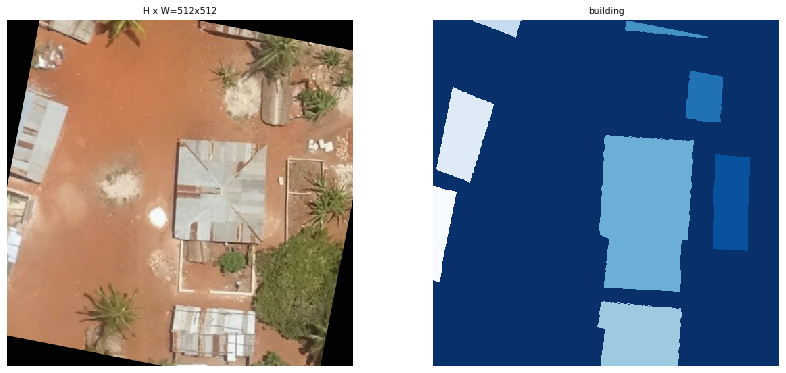

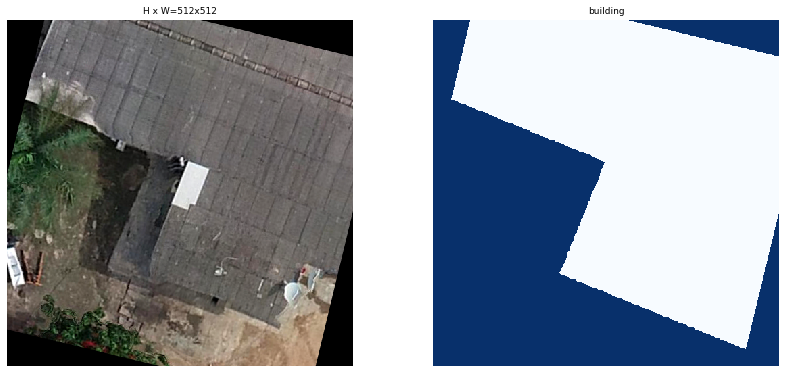

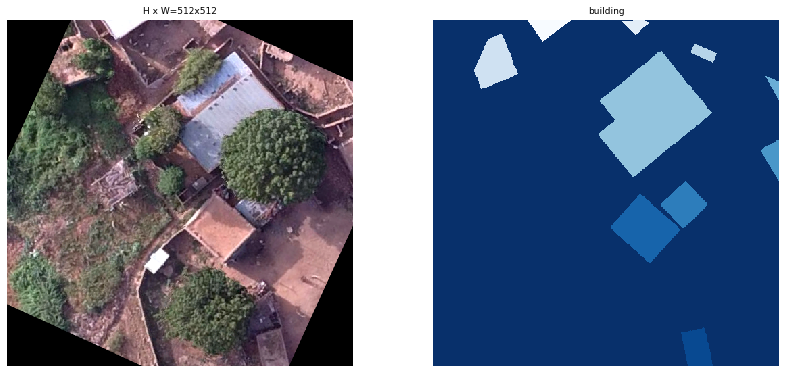

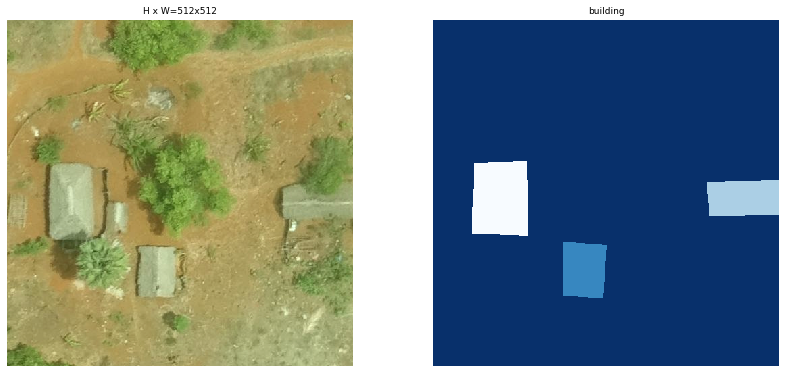

In [39]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (512, 512, 3)         min:    0.00000  max:  239.00000  uint8
mask                     shape: (512, 512, 18)        min:    0.00000  max:    1.00000  uint8


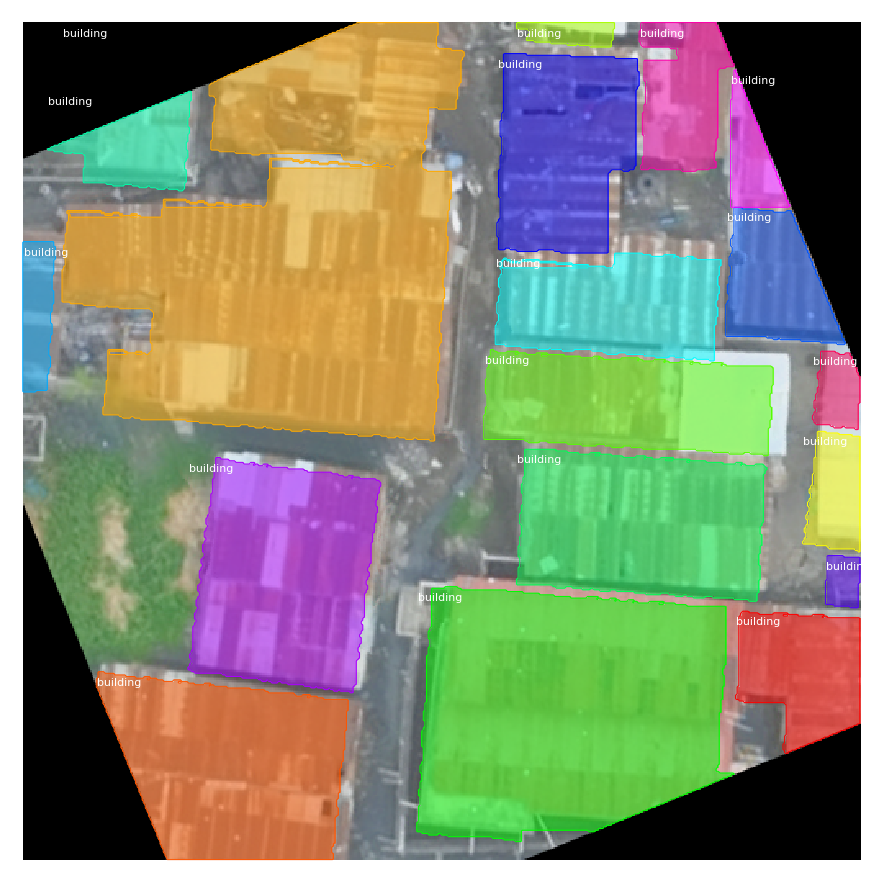

In [40]:
# Example of loading a specific image by its source ID

source_id = "--be4osz1OWQgo4VridBXsFsTONsGbltq4uk_6UUo9U"

# Map source ID to Dataset image_id
# Notice the nucleus prefix: it's the name given to the dataset in NucleusDataset
image_id = dataset.image_from_source_map["building.{}".format(source_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)

log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

In [20]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)

    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 260.8 seconds


###Uncomment the next cell instead of running the above image_stats again, to save 4 minutes.

In [0]:
#import pickle

#with open('/content/drive/My Drive/Capstone/Open Cities Competition/Mask_RCNN/datasets/stats.pickle', 'rb') as f:
#    pickle.dump(stats, f)

Image Count:  4992
Height  mean: 512.00  median: 512.00  min: 512.00  max: 512.00
Width   mean: 512.00  median: 512.00  min: 512.00  max: 512.00
Color   mean (RGB): 128.77 118.85 99.54


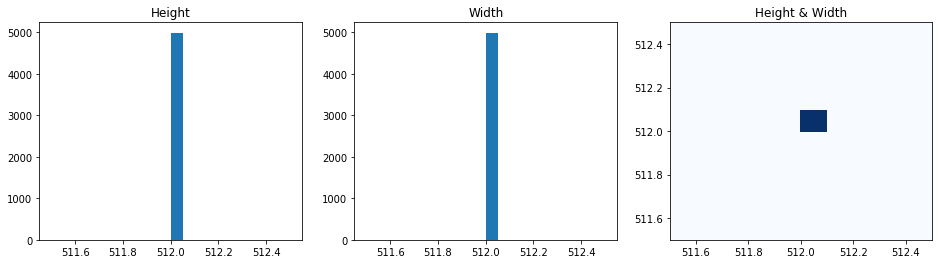

In [41]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

image_id:  3896 62BXknOdL6QELeUyaYxA5tseR__tDjkBqxGcbMOsS6A
Original shape:  (512, 512, 3)
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 7)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (7,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (7, 4)                min:    0.00000  max:  512.00000  int32


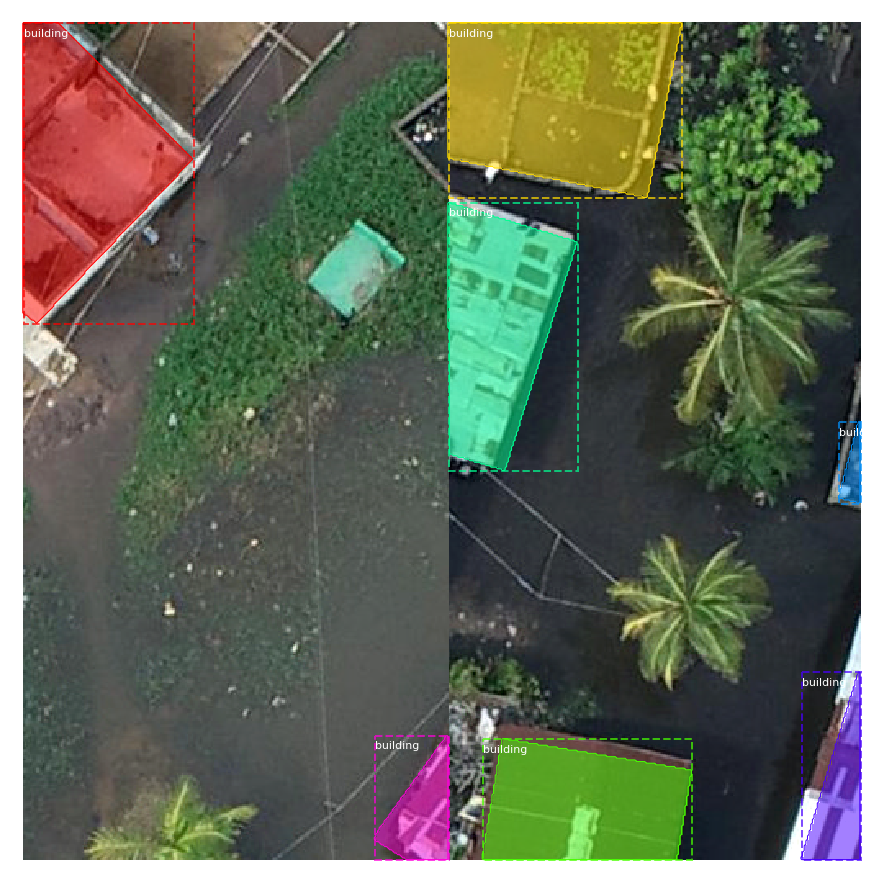

In [23]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (512, 512, 3)         min:    0.00000  max:  251.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 2866.00000  int64
class_ids                shape: (5,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (5, 4)                min:    1.00000  max:  512.00000  int32
mask                     shape: (512, 512, 5)         min:    0.00000  max:    1.00000  uint8


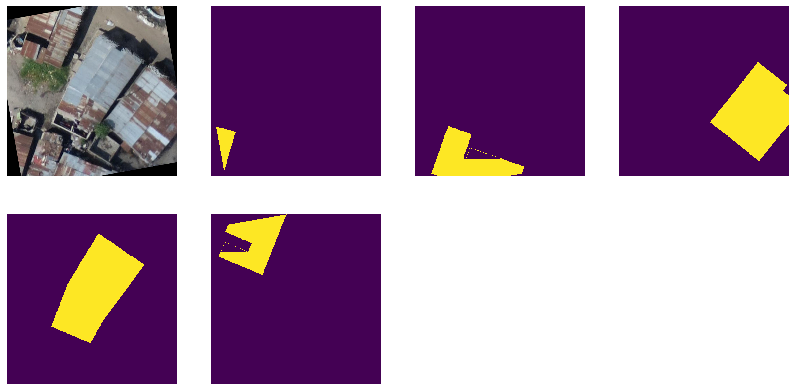

In [24]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

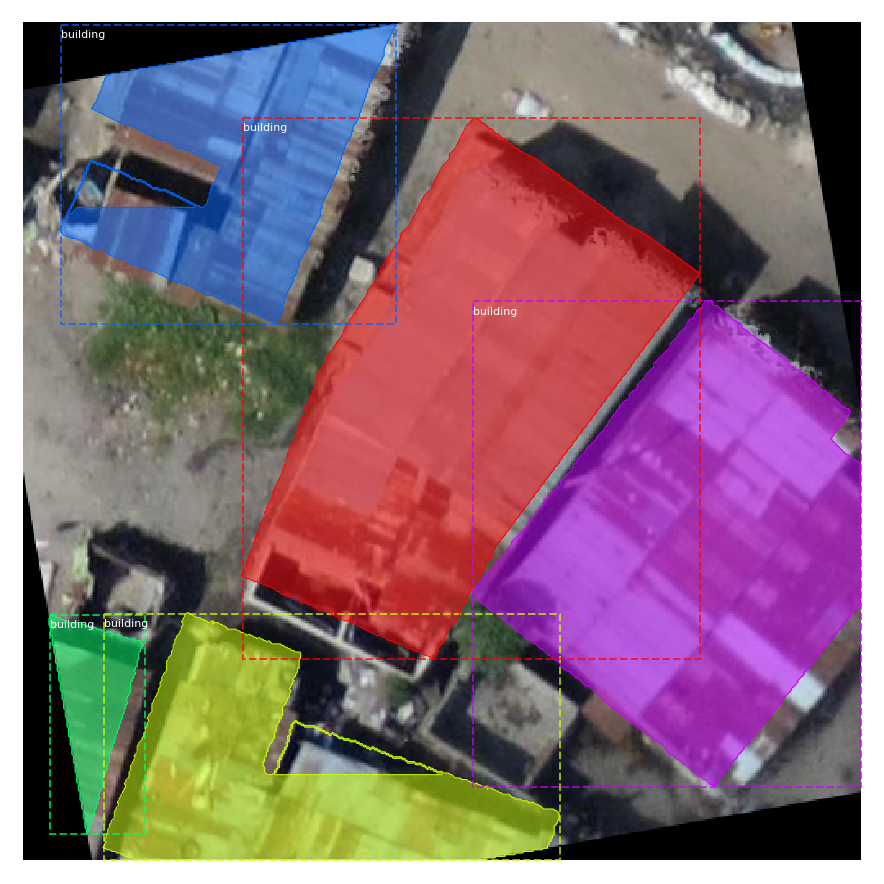

In [25]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

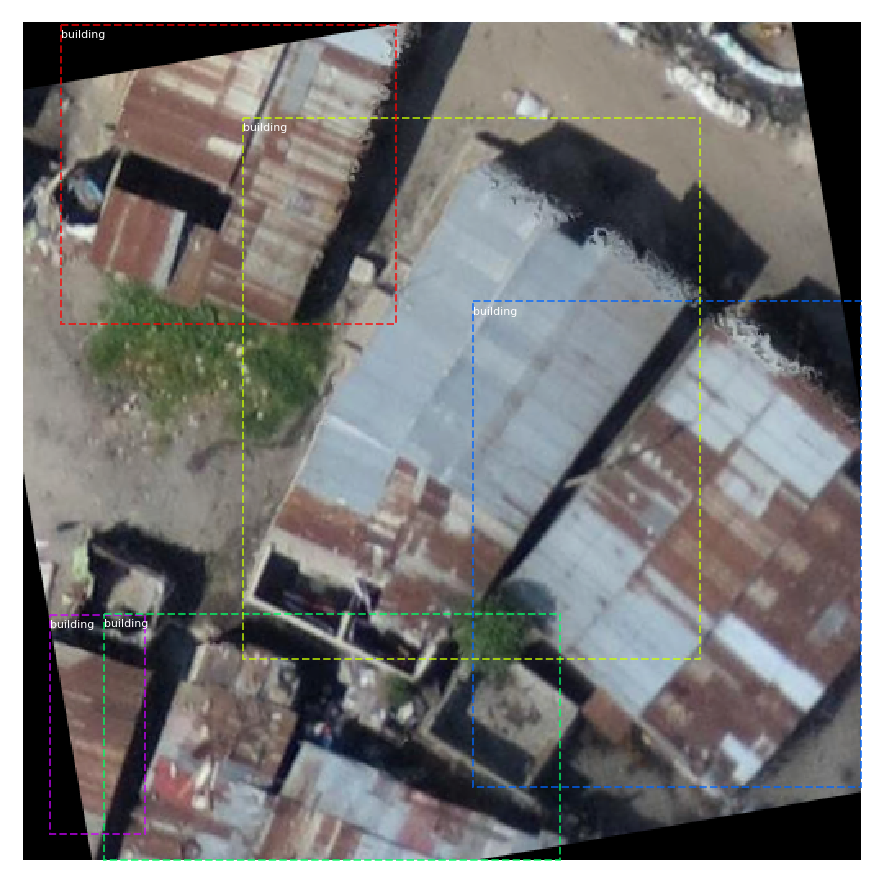

In [26]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [0]:
class RandomCropConfig(BuildingsConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

Count:  16368
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48
Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


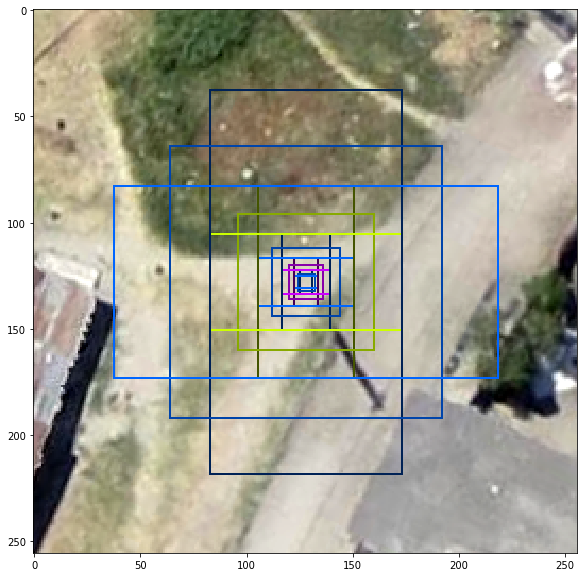

In [42]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, crop_config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

In [0]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, crop_config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [44]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 32, 4)            min:    0.00000  max:  254.00000  int32
mrcnn_class_ids          shape: (4, 32, 1)            min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 32, 2, 4)         min:   -3.07190  max:    2.68867  float32
mrcnn_mask               shape: (4, 32, 28, 28, 2)    min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  256.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 16368, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -3.87246  max:    3.14883  float64
image_id:  3232 ZxjBFoxYdN7cdODCzhIaqwDCyyahj19l7zguERNGHV0


anchors                  shape: (16368, 4)            min:  -90.50967  max:  282.50967  float64
refined_anchors          shape: (1, 4)                min:   -0.00001  max:  213.00000  float32
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 16112
BG                     : 22
building               : 10


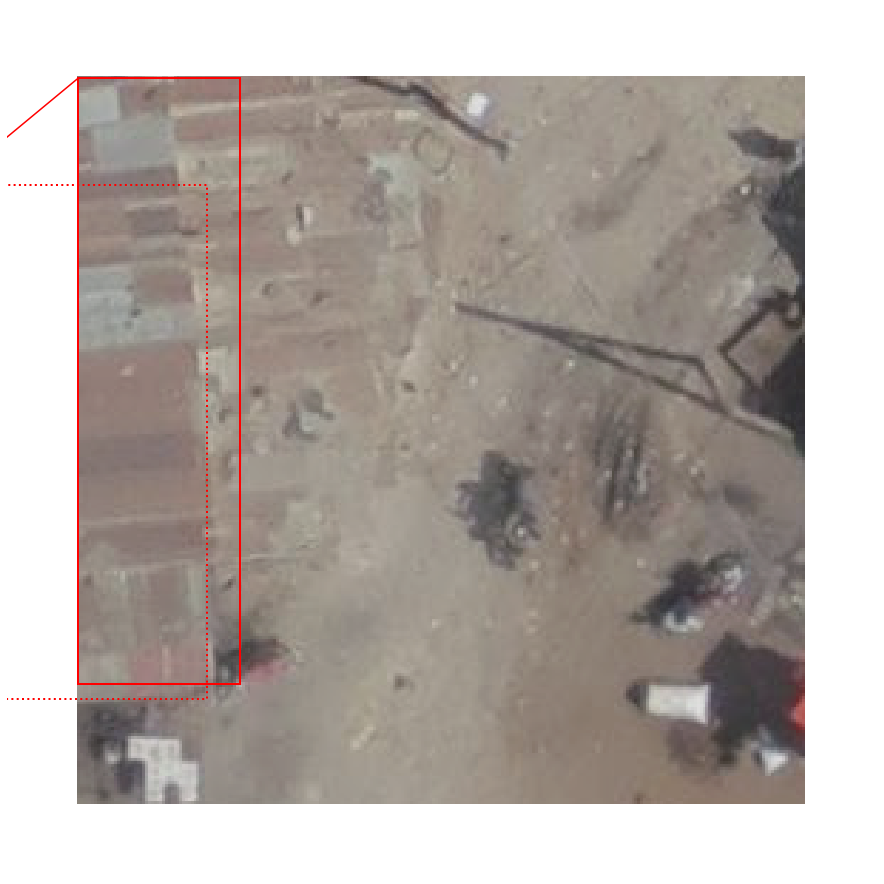

In [45]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

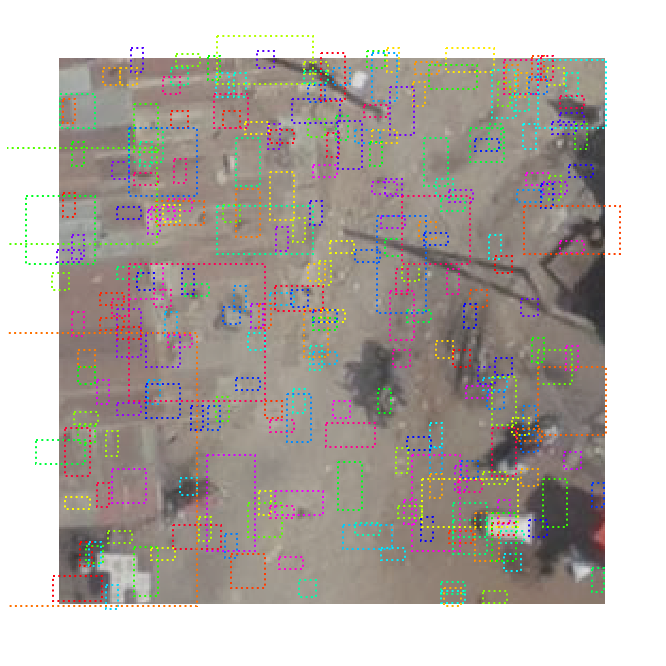

In [46]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

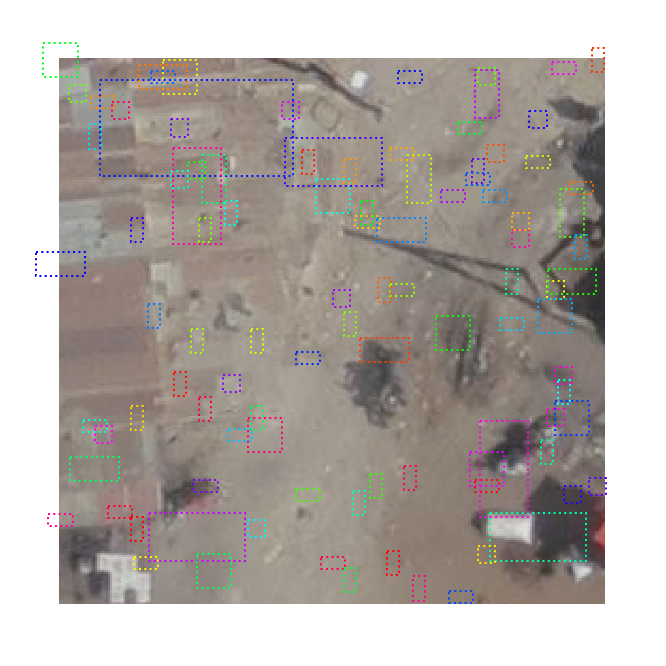

In [47]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

Positive ROIs:  10
Negative ROIs:  22
Positive Ratio: 0.31
Unique ROIs: 32 out of 32


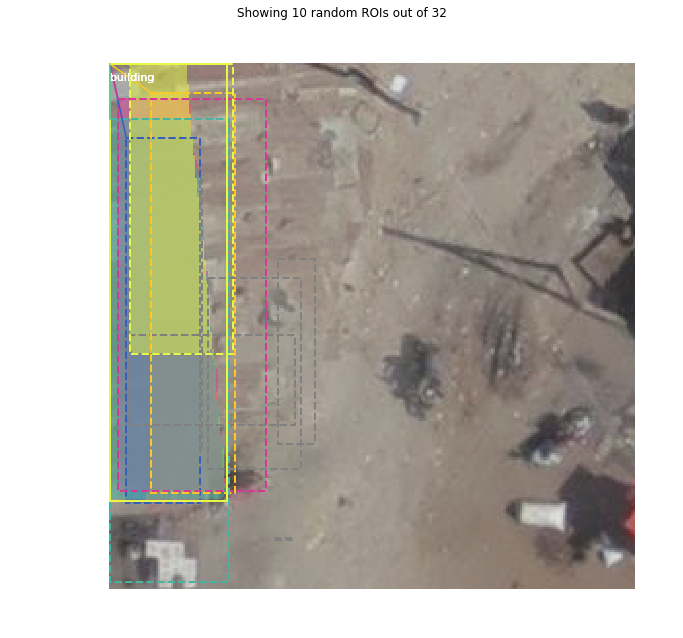

In [48]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

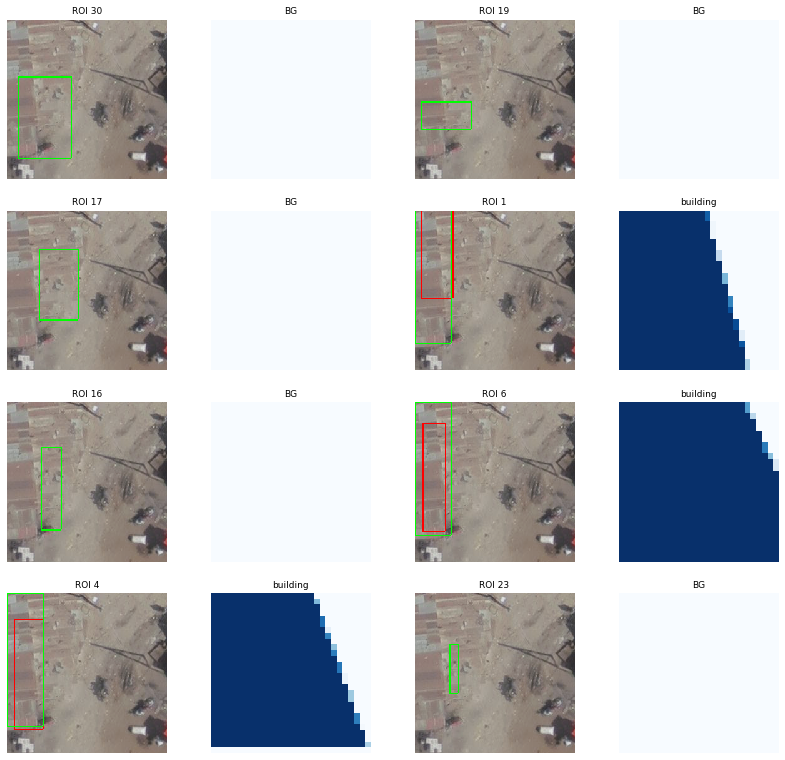

In [49]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [50]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, crop_config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
Average percent: 0.31
